In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

#### for GPU

In [ ]:
tf.config.experimental.list_physical_devices('GPU')

In [ ]:
tf.config.experimental.list_physical_devices(device_type=None)

In [ ]:
tf.test.is_gpu_available()

In [ ]:
physical_device = tf.config.experimental.list_physical_device('GPU')
print("Num GPUs Available: ",len(physical_device))
tf.config.experimental.set_memory_growth(physical_device[0], True)

# Data Prep for Cat vs Dog

The images inclued in the data/cats-dogs directory are a random subset of the full cat and dog data set from the following Kaggle competition: https://www.kaggle.com/c/dogs-vs-cats/data

In [ ]:
# Organize data into train, valid, test dirs
os.chdir('dataset/dogs-vs-cats')
if os.path.isdir('train/dog') is False:
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')
    
    for c in random.sample(glob.glob('Cat/*'), 500):
        shutil.copy(c, 'train/cat')
    for c in random.sample(glob.glob('Dog/*'), 500):
        shutil.copy(c, 'train/dog')
    for c in random.sample(glob.glob('Cat/*'), 100):
        shutil.copy(c, 'valid/cat')
    for c in random.sample(glob.glob('Dog/*'), 100):
        shutil.copy(c, 'valid/dog')
    for c in random.sample(glob.glob('Cat/*'), 50):
        shutil.copy(c, 'test/cat')
    for c in random.sample(glob.glob('Dog/*'), 50):
        shutil.copy(c, 'test/dog')

os.chdir('../../')

In [ ]:
train_path='dataset/dogs-vs-cats/train'
valid_path='dataset/dogs-vs-cats/valid'
test_path='dataset/dogs-vs-cats/test'

In [ ]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat','dog'], batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat','dog'], batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat','dog'], batch_size=10, shuffle=False)

In [ ]:
assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n == 100
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [ ]:
imgs, labels = next(train_batches)

In [ ]:
# This function will plot images in the form of a grid with 1 row and 10 columns where images are place
def plotImages(images_arr):
    fig, axes = plt.subplots(1,10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
plotImages(imgs)
print(labels)

### Build and Train a CNN

In [ ]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2,2), strides=2),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax'),
    
])

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

### Predict

In [ ]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [ ]:
test_batches.classes

In [ ]:
predictions = model.predict(x=test_batches, verbose=0)

In [ ]:
np.round(predictions)

In [ ]:
cm= confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions,axis=-1))

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
test_batches.class_indices

In [ ]:
cm_plot_labels=['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

## Build Fine-tuned VGG16 Model

In [ ]:
# Download model - Internet connection needed
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [ ]:
vgg16_model.summary()

In [ ]:
type(vgg16_model)

In [ ]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [ ]:
model.summary()

In [ ]:
for layer in model.layers:
    layer.trainable = False

In [ ]:
model.add(Dense(units=2, activation='softmax'))

In [ ]:
model.summary()

### Train Fine-tunded VGG16 model

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=5, verbose=2)

### Predict using fine-tuned VGG16 model

In [ ]:
predictions = model.predict(x=test_batches,verbose=0)

In [ ]:
test_batches.classes

In [ ]:
cm= confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions,axis=-1))

In [ ]:
test_batches.class_indices

In [ ]:
cm_plot_labels=['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

## MobileNet

In [ ]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [ ]:
def prepare_image(file):
    img_path = 'data/MobileNet-samples/'
    img=image.load_img(img_path + file, target_size=(224,224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [ ]:
from IPython.display import Image
Image(filename='data/MobileNet-samples/1.JPG', width=300,height=200)

In [ ]:
preprocessed_image = prepare_image('1.JPG')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

In [ ]:
Image(filename='data/MobileNet-samples/2.JPG', width=300,height=200)

In [ ]:
preprocessed_image = prepare_image('2.JPG')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

In [ ]:
Image(filename='data/MobileNet-samples/3.JPG', width=300,height=200)

In [ ]:
preprocessed_image = prepare_image('3.JPG')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

###  Fine-tuned MobileNet on Sign Langugage digits

### Image preparation

Dataset: https://www.kaggle.com/datamunge/sign-language-mnist 
        or https://github.com/ardamavi/Sign-Language-Digits-Dataset
- 10 classes (digit 0-9)
- Class data:
 - class 0: 205 images
 - class 1: 206 images
 - class 3: 206 images
 - class 4: 207 images
 - class 5: 207 images
 - class 6: 207 images
 - class 7: 206 images
 - class 8: 208 images
 - class 9: 204 images

Download data and save in current directory/Sign-Language-Dataset. Extract sub-directories labeled 0-9 and nest directories directly underneath Sign-Language-Digits-Dataset directory. Directory structure look like this:
- Sign-Language-Dataset/
 - 0
 - 1
 - 2
 - ...
 - 9

In [3]:
# Organize data into train, valid, test dirs
os.chdir('Sign-Language-Dataset')
if os.path.isdir('train/0/') is False:
    os.makedirs('train')
    os.makedirs('valid')
    os.makedirs('test')
    
    for i in range(0,10):
        shutil.move(f'{i}','train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')
        
        valid_samples = random.sample(os.listdir(f'train/{i}'),30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')
            
        test_samples = random.sample(os.listdir(f'train/{i}'),5)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')

os.chdir('../')

In [5]:
train_path='Sign-Language-Dataset/train'
valid_path='Sign-Language-Dataset/valid'
test_path='Sign-Language-Dataset/test'

In [6]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)\
    .flow_from_directory(directory=train_path, target_size=(224,224), batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)\
    .flow_from_directory(directory=valid_path, target_size=(224,224), batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)\
    .flow_from_directory(directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


### Modify Model

In [7]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [8]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [9]:
x = mobile.layers[-6].output
output =Dense(units=10, activation='softmax')(x) #functional API model - pass all previous layer

In [10]:
model = Model(inputs=mobile.input, outputs=output)

In [12]:
for layer in model.layers[:23]:
    layer.trainable=False

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

### Train the model

In [14]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
# RUn for more epochs (~30) for better results
model.fit(x=train_batches, validation_data=valid_batches, epochs=30, verbose=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 172 steps, validate for 30 steps
Epoch 1/30
172/172 - 65s - loss: 0.0568 - accuracy: 0.9924 - val_loss: 0.4807 - val_accuracy: 0.8900
Epoch 2/30
172/172 - 64s - loss: 0.0114 - accuracy: 1.0000 - val_loss: 0.5487 - val_accuracy: 0.8167
Epoch 3/30
172/172 - 66s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.5222 - val_accuracy: 0.8200
Epoch 4/30
172/172 - 66s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.5153 - val_accuracy: 0.8267
Epoch 5/30
172/172 - 66s - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.4841 - val_accuracy: 0.8300
Epoch 6/30
172/172 - 65s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.4558 - val_accuracy: 0.8467
Epoch 7/30
172/172 - 65s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.4382 - val_accuracy: 0.8567
Epoch 8/30
172/172 - 65s - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.4339 - val_accuracy: 0.8633
Epoch 9/30
172/172 - 65s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.4217 - val_accuracy: 0.863

### Predict sign language digits

In [17]:
test_labels = test_batches.classes

In [18]:
predictions = model.predict(x=test_batches, verbose=0)

In [19]:
cm= confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [20]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 2 0]
 [0 0 0 4 0 0 0 0 1 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 2 0 3 0 0 0]
 [0 0 0 0 0 0 0 3 2 0]
 [0 0 0 0 0 0 0 0 4 1]
 [0 0 0 0 0 0 0 0 0 5]]


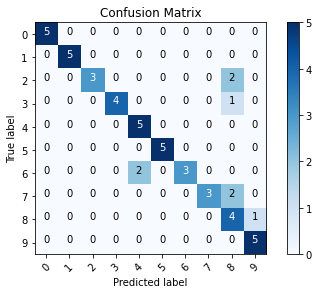

In [22]:
# Train the model for more epochs to see better results
cm_plot_labels=['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')